In [4]:
import numpy as np
from numpy import sin,cos,pi
import matplotlib.pyplot as plt
import control as ct
import cv2
import time

In [181]:
class Robot():
    angle=0.001/180*pi
    g=9.81
    p1,p2,p3=1,1,0
    animationInterval=1/25
    def __init__(self,R,l,r,R2,R3,m1,m2,m3,I1,I2,I3,ID,maxOmega,torqueLimit):
        self.R=R
        self.l=l
        self.r=r
        self.R2=R2
        self.R3=R3
        self.m1=m1
        self.m2=m2
        self.m3=m3
        self.I1=I1
        self.I2=I2
        self.I3=I3
        self.ID=ID
        self.maxOmega=maxOmega
        self.beta=np.arcsin(r/l)
        self.torqueLimit=torqueLimit
        self.p10,self.p20,self.p30=0,0,0
        self.Calibrate0()
    # region definition
    def P1(self,theta,phi):
        R=self.R
        return np.array([[R*theta],[R]])
    def Q1(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        return np.array([[R*theta-l*sin(theta)],[R-l*cos(theta)]])
    def M(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        alpha=np.arcsin(r/l*sin(phi))
        return self.Q1(theta,phi)+r*np.array([[sin(theta+phi-alpha)],[cos(theta+phi-alpha)]])
    def Q2(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        alpha=np.arcsin(r/l*sin(phi))
        return self.Q1(theta,phi)+2*r*np.array([[sin(theta+phi-alpha)],[cos(theta+phi-alpha)]])
    def P2(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        alpha=np.arcsin(r/l*sin(phi))
        return self.Q2(theta,phi)+l*np.array([[sin(theta-2*alpha)],[cos(theta-2*alpha)]])
    def M1(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        return self.Q1(theta,phi)+R2*np.array([[-sin(theta)],[-cos(theta)]])
    def M2(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        alpha=np.arcsin(r/l*sin(phi))
        return self.Q2(theta,phi)+R2*np.array([[-sin(theta-2*alpha)],[-cos(theta-2*alpha)]])
    def M3(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        alpha=np.arcsin(r/l*sin(phi))
        return self.M(theta,phi)+R3*np.array([[sin(theta-alpha)],[cos(theta-alpha)]])
    def Mt(self,theta,phi):
        mt=self.m1+self.m2+self.m3
        return (self.m1*self.M1(theta,phi)+self.m2*self.M2(theta,phi)+self.m3*self.M3(theta,phi))/mt
    # endregion
    # region M1
    def dM1dtheta(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.M1(theta+self.angle/2,phi)
        M0=self.M1(theta-self.angle/2,phi)
        return (M1-M0)/self.angle
    def dM1dphi(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.M1(theta,phi+self.angle/2)
        M0=self.M1(theta,phi-self.angle/2)
        return (M1-M0)/self.angle
    def dM1dtheta2(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.dM1dtheta(theta+self.angle/2,phi)
        M0=self.dM1dtheta(theta-self.angle/2,phi)
        return (M1-M0)/self.angle
    def dM1dphi2(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.dM1dphi(theta,phi+self.angle/2)
        M0=self.dM1dphi(theta,phi-self.angle/2)
        return (M1-M0)/self.angle
    def dM1dthetadphi(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.dM1dtheta(theta,phi+self.angle/2)
        M0=self.dM1dtheta(theta,phi-self.angle/2)
        return (M1-M0)/self.angle
    def dM1dt(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        thetadot,phidot=np.random.random(2)
        temp=np.array([[R],[0]])*thetadot+(l+R2)*np.array([[-cos(theta)],[sin(theta)]])*thetadot
        # print(temp)
        return self.dM1dtheta(theta,phi)*thetadot+self.dM1dphi(theta,phi)*phidot
    def ddM1dt2(self,theta,phi,thetadot2,phidot2,thetadot,phidot):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        temp=np.array([[R],[0]])*thetadot2+(l+R2)*np.array([[-cos(theta)],[sin(theta)]])*thetadot2+(l+R2)*np.array([[sin(theta)],[cos(theta)]])*thetadot**2
        # print(temp)
        # return self.dM1dtheta(theta,phi)*thetadot2+self.dM1dphi(theta,phi)*phidot2+self.dM1dtheta2(theta,phi)*thetadot**2+self.dM1dphi2(theta,phi)*phidot**2+2*self.dM1dthetadphi(theta,phi)*thetadot*phidot
        return np.hstack((self.dM1dtheta(theta,phi),self.dM1dphi(theta,phi),self.dM1dtheta2(theta,phi)*thetadot**2+self.dM1dphi2(theta,phi)*phidot**2+2*self.dM1dthetadphi(theta,phi)*thetadot*phidot))
    def Q1theta(self,theta,phi,thetadot,phidot):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        # thetadot2,phidot2=np.random.random(2)
        # temp=(R**2-2*R*(l+R2)*cos(theta)+(l+R2)**2)*thetadot2+R*(l+R2)*sin(theta)*thetadot**2
        # print(temp)
        # return self.dM1dtheta(theta,phi).T@self.ddM1dt2(theta,phi,thetadot2,phidot2,thetadot,phidot)
        # print(self.dM1dtheta(theta,phi).T@self.ddM1dt2(theta,phi,0,0,thetadot,phidot))
        return np.array([[(R**2-2*R*(l+R2)*cos(theta)+(l+R2)**2),0,R*(l+R2)*sin(theta)*thetadot**2]])
    def Q1phi(self,theta,phi,thetadot,phidot):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        # thetadot2,phidot2=np.random.random(2)
        # temp=0
        # print(temp)
        # return self.dM1dphi(theta,phi).T@self.ddM1dt2(theta,phi,thetadot2,phidot2,thetadot,phidot)
        # print(self.dM1dphi(theta,phi).T@self.ddM1dt2(theta,phi,0,0,thetadot,phidot))
        return np.array([[0,0,0]])
    # endregion
    # region M2
    def dM2dtheta(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.M2(theta+self.angle/2,phi)
        M0=self.M2(theta-self.angle/2,phi)
        return (M1-M0)/self.angle
    def dM2dphi(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.M2(theta,phi+self.angle/2)
        M0=self.M2(theta,phi-self.angle/2)
        return (M1-M0)/self.angle
    def dM2dtheta2(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.dM2dtheta(theta+self.angle/2,phi)
        M0=self.dM2dtheta(theta-self.angle/2,phi)
        return (M1-M0)/self.angle
    def dM2dphi2(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.dM2dphi(theta,phi+self.angle/2)
        M0=self.dM2dphi(theta,phi-self.angle/2)
        return (M1-M0)/self.angle
    def dM2dthetadphi(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.dM2dtheta(theta,phi+self.angle/2)
        M0=self.dM2dtheta(theta,phi-self.angle/2)
        return (M1-M0)/self.angle
    def dM2dt(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        thetadot,phidot=np.random.random(2)
        alpha=np.arcsin(r/l*sin(phi))
        alphadot=r/l*cos(phi)/cos(alpha)*phidot
        temp=(np.array([[R],[0]])*thetadot+l*np.array([[-cos(theta)],[sin(theta)]])*thetadot
              +2*r*np.array([[cos(theta+phi-alpha)],[-sin(theta+phi-alpha)]])*(thetadot+phidot-alphadot)
              +R2*np.array([[-cos(theta-2*alpha)],[sin(theta-2*alpha)]])*(thetadot-2*alphadot)
              )
        # print(temp)
        return self.dM2dtheta(theta,phi)*thetadot+self.dM2dphi(theta,phi)*phidot
    def ddM2dt2(self,theta,phi,thetadot2,phidot2,thetadot,phidot):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        alpha=np.arcsin(r/l*sin(phi))
        alphadot=r/l*cos(phi)/cos(alpha)*phidot
        alphadot2=r/l*cos(phi)/cos(alpha)*phidot2-r/l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        temp=(np.array([[R],[0]])*thetadot2+l*np.array([[-cos(theta)],[sin(theta)]])*thetadot2
              +2*r*np.array([[cos(theta+phi-alpha)],[-sin(theta+phi-alpha)]])*(thetadot2+phidot2-alphadot2)
              +R2*np.array([[-cos(theta-2*alpha)],[sin(theta-2*alpha)]])*(thetadot2-2*alphadot2)+l*np.array([[sin(theta)],[cos(theta)]])*thetadot**2
              +2*r*np.array([[-sin(theta+phi-alpha)],[-cos(theta+phi-alpha)]])*(thetadot+phidot-alphadot)**2
              +R2*np.array([[sin(theta-2*alpha)],[cos(theta-2*alpha)]])*(thetadot-2*alphadot)**2
              )
        # print(temp)
        # return self.dM2dtheta(theta,phi)*thetadot2+self.dM2dphi(theta,phi)*phidot2+self.dM2dtheta2(theta,phi)*thetadot**2+self.dM2dphi2(theta,phi)*phidot**2+2*self.dM2dthetadphi(theta,phi)*thetadot*phidot
        return np.hstack((self.dM2dtheta(theta,phi),self.dM2dphi(theta,phi),self.dM2dtheta2(theta,phi)*thetadot**2+self.dM2dphi2(theta,phi)*phidot**2+2*self.dM2dthetadphi(theta,phi)*thetadot*phidot))
    def Q2theta(self,theta,phi,thetadot,phidot):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        # thetadot2,phidot2=np.random.random(2)
        alpha=np.arcsin(r/l*sin(phi))
        alphadot=r/l*cos(phi)/cos(alpha)*phidot
        # alphadot2=r/l*cos(phi)/cos(alpha)*phidot2-r/l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        dalphadot2dphidot2=r/l*cos(phi)/cos(alpha)
        alphadot2Others=-r/l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        # temp=(R**2*thetadot2-R*l*cos(theta)*thetadot2+2*R*r*cos(theta+phi-alpha)*(thetadot2+phidot2-alphadot2)
        #       -R*R2*cos(theta-2*alpha)*(thetadot2-2*alphadot2)+R*l*sin(theta)*thetadot**2
        #       -2*R*r*sin(theta+phi-alpha)*(thetadot+phidot-alphadot)**2+R*R2*sin(theta-2*alpha)*(thetadot-2*alphadot)**2
        #       -R*l*cos(theta)*thetadot2+l**2*thetadot2-2*r*l*cos(phi-alpha)*(thetadot2+phidot2-alphadot2)+R2*l*cos(2*alpha)*(thetadot2-2*alphadot2)
        #       +2*r*l*sin(phi-alpha)*(thetadot+phidot-alphadot)**2+R2*l*sin(2*alpha)*(thetadot-2*alphadot)**2
              
        #       +2*R*r*cos(theta+phi-alpha)*thetadot2-2*r*l*cos(phi-alpha)*thetadot2+4*r**2*(thetadot2+phidot2-alphadot2)
        #       -2*r*R2*cos(phi+alpha)*(thetadot2-2*alphadot2)-2*r*l*sin(phi-alpha)*thetadot**2
        #       -2*r*R2*sin(phi+alpha)*(thetadot-2*alphadot)**2
              
        #       -R*R2*cos(theta-2*alpha)*thetadot2+l*R2*cos(2*alpha)*thetadot2-2*r*R2*cos(phi+alpha)*(thetadot2+phidot2-alphadot2)+R2**2*(thetadot2-2*alphadot2)
        #       -l*R2*sin(2*alpha)*thetadot**2+2*r*R2*sin(phi+alpha)*(thetadot+phidot-alphadot)**2
        #       )
        tempthetadot2=(R**2+l**2+4*r**2+R2**2-2*R*l*cos(theta)+4*R*r*cos(theta+phi-alpha)-2*R*R2*cos(theta-2*alpha)
                       -4*l*r*cos(phi-alpha)+2*l*R2*cos(2*alpha)-4*r*R2*cos(phi+alpha))
        tempphidot2=(4*r**2+2*R*r*cos(theta+phi-alpha)-2*l*r*cos(phi-alpha)-2*r*R2*cos(phi+alpha))
        tempalphadot2=(-4*r**2-2*R2**2-2*R*r*cos(theta+phi-alpha)+2*R*R2*cos(theta-2*alpha)+2*l*r*cos(phi-alpha)
                       -2*l*R2*cos(2*alpha)+6*r*R2*cos(phi+alpha))
        tempothers=(
            R*l*sin(theta)*thetadot**2-2*R*r*sin(theta+phi-alpha)*(thetadot+phidot-alphadot)**2+R*R2*sin(theta-2*alpha)*(thetadot-2*alphadot)**2
            +2*l*r*sin(phi-alpha)*(2*thetadot+phidot-alphadot)*(phidot-alphadot)
            +l*R2*sin(2*alpha)*(2*thetadot-2*alphadot)*(-2*alphadot)
            +2*r*R2*sin(phi+alpha)*(2*thetadot+phidot-3*alphadot)*(phidot+alphadot)
        )
        # temp=tempthetadot2*thetadot2+tempphidot2*phidot2+tempalphadot2*alphadot2+tempothers
        # print(temp)
        # return self.dM2dtheta(theta,phi).T@self.ddM2dt2(theta,phi,thetadot2,phidot2,thetadot,phidot)
        # print(self.dM2dtheta(theta,phi).T@self.ddM2dt2(theta,phi,0,0,thetadot,phidot))
        return np.array([[tempthetadot2,tempphidot2+tempalphadot2*dalphadot2dphidot2,tempalphadot2*alphadot2Others+tempothers]])
    def Q2phi(self,theta,phi,thetadot,phidot):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        # thetadot2,phidot2=np.random.random(2)
        alpha=np.arcsin(r/l*sin(phi))
        alphadot=r/l*cos(phi)/cos(alpha)*phidot
        # alphadot2=r/l*cos(phi)/cos(alpha)*phidot2-r/l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        dalphadot2dphidot2=r/l*cos(phi)/cos(alpha)
        alphadot2Others=-r/l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        # temp=(
        #     (1-r/l*cos(phi)/cos(alpha))*(
        #         +2*R*r*cos(theta+phi-alpha)*thetadot2-2*r*l*cos(phi-alpha)*thetadot2+4*r**2*(thetadot2+phidot2-alphadot2)
        #         -2*r*R2*cos(phi+alpha)*(thetadot2-2*alphadot2)-2*r*l*sin(phi-alpha)*thetadot**2
        #         -2*r*R2*sin(phi+alpha)*(thetadot-2*alphadot)**2
        #     )
        #     +(-2*r/l*cos(phi)/cos(alpha))*(
        #         -R*R2*cos(theta-2*alpha)*thetadot2+l*R2*cos(2*alpha)*thetadot2-2*r*R2*cos(phi+alpha)*(thetadot2+phidot2-alphadot2)+R2**2*(thetadot2-2*alphadot2)
        #         -l*R2*sin(2*alpha)*thetadot**2+2*r*R2*sin(phi+alpha)*(thetadot+phidot-alphadot)**2
        #     )
        # )
        tempthetadot2=(
            (1-r/l*cos(phi)/cos(alpha))*(4*r**2+2*R*r*cos(theta+phi-alpha)-2*l*r*cos(phi-alpha)-2*r*R2*cos(phi+alpha))
            +(-2*r/l*cos(phi)/cos(alpha))*(R2**2-R*R2*cos(theta-2*alpha)+l*R2*cos(2*alpha)-2*r*R2*cos(phi+alpha))
        )
        tempphidot2=(
            (1-r/l*cos(phi)/cos(alpha))*(4*r**2)
            +(-2*r/l*cos(phi)/cos(alpha))*(-2*r*R2*cos(phi+alpha))
        )
        tempalphadot2=(
            (1-r/l*cos(phi)/cos(alpha))*(-4*r**2+4*r*R2*cos(phi+alpha))
            +(-2*r/l*cos(phi)/cos(alpha))*(-2*R2**2+2*r*R2*cos(phi+alpha))
        )
        tempothers=(
            (1-r/l*cos(phi)/cos(alpha))*(-2*l*r*sin(phi-alpha)*thetadot**2-2*r*R2*sin(phi+alpha)*(thetadot-2*alphadot)**2)
            +(-2*r/l*cos(phi)/cos(alpha))*(-l*R2*sin(2*alpha)*thetadot**2+2*r*R2*sin(phi+alpha)*(thetadot+phidot-alphadot)**2)
        )
        # temp=tempthetadot2*thetadot2+tempphidot2*phidot2+tempalphadot2*alphadot2+tempothers
        # print(temp)
        # return self.dM2dphi(theta,phi).T@self.ddM2dt2(theta,phi,thetadot2,phidot2,thetadot,phidot)
        # print(self.dM2dphi(theta,phi).T@self.ddM2dt2(theta,phi,0,0,thetadot,phidot))
        return np.array([[tempthetadot2,tempphidot2+tempalphadot2*dalphadot2dphidot2,tempalphadot2*alphadot2Others+tempothers]])
    # endregion
    # region M3
    def dM3dtheta(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.M3(theta+self.angle/2,phi)
        M0=self.M3(theta-self.angle/2,phi)
        return (M1-M0)/self.angle
    def dM3dphi(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.M3(theta,phi+self.angle/2)
        M0=self.M3(theta,phi-self.angle/2)
        return (M1-M0)/self.angle
    def dM3dtheta2(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.dM3dtheta(theta+self.angle/2,phi)
        M0=self.dM3dtheta(theta-self.angle/2,phi)
        return (M1-M0)/self.angle
    def dM3dphi2(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.dM3dphi(theta,phi+self.angle/2)
        M0=self.dM3dphi(theta,phi-self.angle/2)
        return (M1-M0)/self.angle
    def dM3dthetadphi(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        M1=self.dM3dtheta(theta,phi+self.angle/2)
        M0=self.dM3dtheta(theta,phi-self.angle/2)
        return (M1-M0)/self.angle
    def dM3dt(self,theta,phi):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        thetadot,phidot=np.random.random(2)
        alpha=np.arcsin(r/l*sin(phi))
        alphadot=r/l*cos(phi)/cos(alpha)*phidot
        temp=(np.array([[R],[0]])*thetadot+l*np.array([[-cos(theta)],[sin(theta)]])*thetadot
              +r*np.array([[cos(theta+phi-alpha)],[-sin(theta+phi-alpha)]])*(thetadot+phidot-alphadot)
              +R3*np.array([[cos(theta-alpha)],[-sin(theta-alpha)]])*(thetadot-alphadot)
              )
        # print(temp)
        return self.dM3dtheta(theta,phi)*thetadot+self.dM3dphi(theta,phi)*phidot
    def ddM3dt2(self,theta,phi,thetadot2,phidot2,thetadot,phidot):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        alpha=np.arcsin(r/l*sin(phi))
        alphadot=r/l*cos(phi)/cos(alpha)*phidot
        alphadot2=r/l*cos(phi)/cos(alpha)*phidot2-r/l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        # temp=(np.array([[R],[0]])*thetadot2+l*np.array([[-cos(theta)],[sin(theta)]])*thetadot2
        #       +r*np.array([[cos(theta+phi-alpha)],[-sin(theta+phi-alpha)]])*(thetadot2+phidot2-alphadot2)
        #       +R3*np.array([[cos(theta-alpha)],[-sin(theta-alpha)]])*(thetadot2-alphadot2)+l*np.array([[sin(theta)],[cos(theta)]])*thetadot**2
        #       +r*np.array([[-sin(theta+phi-alpha)],[-cos(theta+phi-alpha)]])*(thetadot+phidot-alphadot)**2
        #       +R3*np.array([[-sin(theta-alpha)],[-cos(theta-alpha)]])*(thetadot-alphadot)**2
        #       )
        # print(temp)
        # return self.dM3dtheta(theta,phi)*thetadot2+self.dM3dphi(theta,phi)*phidot2+self.dM3dtheta2(theta,phi)*thetadot**2+self.dM3dphi2(theta,phi)*phidot**2+2*self.dM3dthetadphi(theta,phi)*thetadot*phidot
        return np.hstack((self.dM3dtheta(theta,phi),self.dM3dphi(theta,phi),self.dM3dtheta2(theta,phi)*thetadot**2+self.dM3dphi2(theta,phi)*phidot**2+2*self.dM3dthetadphi(theta,phi)*thetadot*phidot))
    def Q3theta(self,theta,phi,thetadot,phidot):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        # thetadot2,phidot2=np.random.random(2)
        alpha=np.arcsin(r/l*sin(phi))
        alphadot=r/l*cos(phi)/cos(alpha)*phidot
        # alphadot2=r/l*cos(phi)/cos(alpha)*phidot2-r/l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        dalphadot2dphidot2=r/l*cos(phi)/cos(alpha)
        alphadot2Others=-r/l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        # temp=(R**2*thetadot2-R*l*cos(theta)*thetadot2+R*r*cos(theta+phi-alpha)*(thetadot2+phidot2-alphadot2)
        #       +R*R3*cos(theta-alpha)*(thetadot2-alphadot2)+R*l*sin(theta)*thetadot**2
        #       -R*r*sin(theta+phi-alpha)*(thetadot+phidot-alphadot)**2-R*R3*sin(theta-alpha)*(thetadot-alphadot)**2
        #       -R*l*cos(theta)*thetadot2+l**2*thetadot2-r*l*cos(phi-alpha)*(thetadot2+phidot2-alphadot2)-R3*l*cos(alpha)*(thetadot2-alphadot2)
        #       +r*l*sin(phi-alpha)*(thetadot+phidot-alphadot)**2-R3*l*sin(alpha)*(thetadot-alphadot)**2
              
        #       +R*r*cos(theta+phi-alpha)*thetadot2-r*l*cos(phi-alpha)*thetadot2+r**2*(thetadot2+phidot2-alphadot2)+r*R3*cos(phi)*(thetadot2-alphadot2)
        #       -r*l*sin(phi-alpha)*thetadot**2+r*R3*sin(phi)*(thetadot-alphadot)**2
              
        #       +R*R3*cos(theta-alpha)*thetadot2-l*R3*cos(alpha)*thetadot2+r*R3*cos(phi)*(thetadot2+phidot2-alphadot2)+R3**2*(thetadot2-alphadot2)
        #       +l*R3*sin(alpha)*thetadot**2-r*R3*sin(phi)*(thetadot+phidot-alphadot)**2
        #       )
        tempthetadot2=(R**2+l**2+r**2+R3**2-2*R*l*cos(theta)+2*R*r*cos(theta+phi-alpha)+2*R*R3*cos(theta-alpha)
                       -2*l*r*cos(phi-alpha)-2*l*R3*cos(alpha)+2*r*R3*cos(phi))
        tempphidot2=(r**2+R*r*cos(theta+phi-alpha)-l*r*cos(phi-alpha)+r*R3*cos(phi))
        tempalphadot2=(-r**2-R3**2-R*r*cos(theta+phi-alpha)-R*R3*cos(theta-alpha)+l*r*cos(phi-alpha)+l*R3*cos(alpha)
                       -2*r*R3*cos(phi))
        tempothers=(
            R*l*sin(theta)*thetadot**2-R*r*sin(theta+phi-alpha)*(thetadot+phidot-alphadot)**2-R*R3*sin(theta-alpha)*(thetadot-alphadot)**2
            +l*r*sin(phi-alpha)*(2*thetadot+phidot-alphadot)*(phidot-alphadot)
            +l*R3*sin(alpha)*(2*thetadot-alphadot)*(alphadot)
            +r*R3*sin(phi)*(2*thetadot+phidot-2*alphadot)*(-phidot)
        )
        # temp=tempthetadot2*thetadot2+tempphidot2*phidot2+tempalphadot2*alphadot2+tempothers
        # print(temp)
        # return self.dM3dtheta(theta,phi).T@self.ddM3dt2(theta,phi,thetadot2,phidot2,thetadot,phidot)
        # print(self.dM3dtheta(theta,phi).T@self.ddM3dt2(theta,phi,0,0,thetadot,phidot))
        return np.array([[tempthetadot2,tempphidot2+tempalphadot2*dalphadot2dphidot2,tempalphadot2*alphadot2Others+tempothers]])
    def Q3phi(self,theta,phi,thetadot,phidot):
        R=self.R
        l=self.l
        r=self.r
        R2=self.R2
        R3=self.R3
        # thetadot2,phidot2=np.random.random(2)
        alpha=np.arcsin(r/l*sin(phi))
        alphadot=r/l*cos(phi)/cos(alpha)*phidot
        # alphadot2=r/l*cos(phi)/cos(alpha)*phidot2-r/l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        dalphadot2dphidot2=r/l*cos(phi)/cos(alpha)
        alphadot2Others=-r/l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        # temp=(
        #     (1-r/l*cos(phi)/cos(alpha))*(
        #         +R*r*cos(theta+phi-alpha)*thetadot2-r*l*cos(phi-alpha)*thetadot2+r**2*(thetadot2+phidot2-alphadot2)+r*R3*cos(phi)*(thetadot2-alphadot2)
        #         -r*l*sin(phi-alpha)*thetadot**2+r*R3*sin(phi)*(thetadot-alphadot)**2
        #     )
        #     +(-r/l*cos(phi)/cos(alpha))*(
        #         +R*R3*cos(theta-alpha)*thetadot2-l*R3*cos(alpha)*thetadot2+r*R3*cos(phi)*(thetadot2+phidot2-alphadot2)+R3**2*(thetadot2-alphadot2)
        #         +l*R3*sin(alpha)*thetadot**2-r*R3*sin(phi)*(thetadot+phidot-alphadot)**2
        #     )
        # )
        tempthetadot2=(
            (1-r/l*cos(phi)/cos(alpha))*(r**2+R*r*cos(theta+phi-alpha)-l*r*cos(phi-alpha)+r*R3*cos(phi))
            +(-r/l*cos(phi)/cos(alpha))*(R3**2+R*R3*cos(theta-alpha)-l*R3*cos(alpha)+r*R3*cos(phi))
        )
        tempphidot2=(
            (1-r/l*cos(phi)/cos(alpha))*(r**2)
            +(-r/l*cos(phi)/cos(alpha))*(r*R3*cos(phi))
        )
        tempalphadot2=(
            (1-r/l*cos(phi)/cos(alpha))*(-r**2-r*R3*cos(phi))
            +(-r/l*cos(phi)/cos(alpha))*(-R3**2-r*R3*cos(phi))
        )
        tempothers=(
            (1-r/l*cos(phi)/cos(alpha))*(-l*r*sin(phi-alpha)*thetadot**2+r*R3*sin(phi)*(thetadot-alphadot)**2)
            +(-r/l*cos(phi)/cos(alpha))*(l*R3*sin(alpha)*thetadot**2-r*R3*sin(phi)*(thetadot+phidot-alphadot)**2)
        )
        # temp=tempthetadot2*thetadot2+tempphidot2*phidot2+tempalphadot2*alphadot2+tempothers
        # print(temp)
        # return self.dM3dphi(theta,phi).T@self.ddM3dt2(theta,phi,thetadot2,phidot2,thetadot,phidot)
        # print(self.dM3dphi(theta,phi).T@self.ddM3dt2(theta,phi,0,0,thetadot,phidot))
        return np.array([[tempthetadot2,tempphidot2+tempalphadot2*dalphadot2dphidot2,tempalphadot2*alphadot2Others+tempothers]])
    # endregion
    # region rotational KE and potential energy
    def KE(self,theta,phi,thetadot,phidot):
        alpha=np.arcsin(self.r/self.l*sin(phi))
        alphadot=self.r/self.l*cos(phi)/cos(alpha)*phidot
        return self.I1/2*thetadot**2+self.I2/2*(thetadot-2*alphadot)**2+self.I3/2*(thetadot-alphadot)**2+self.ID/2*(thetadot-alphadot+phidot)**2
    def dKEdthetadot(self,theta,phi,thetadot,phidot):
        alpha=np.arcsin(self.r/self.l*sin(phi))
        tempthetadot2=self.I1+self.I2+self.I3+self.ID
        tempphidot2=self.ID
        tempalphadot2=-2*self.I2-self.I3-self.ID
        temp=np.array([[tempthetadot2,tempphidot2+tempalphadot2*self.r/self.l*cos(phi)/cos(alpha)]])
        KE1=self.KE(theta,phi,thetadot+self.angle/2,phidot)
        KE0=self.KE(theta,phi,thetadot-self.angle/2,phidot)
        # print((KE1-KE0)/self.angle)
        # print(temp@np.array([[thetadot],[phidot]]))
        return temp
    def dKEdphidot(self,theta,phi,thetadot,phidot):
        alpha=np.arcsin(self.r/self.l*sin(phi))
        tempthetadot2=self.ID+(-2*self.I2-self.I3-self.ID)*self.r/self.l*cos(phi)/cos(alpha)
        tempphidot2=self.ID*(1-self.r/self.l*cos(phi)/cos(alpha))
        tempalphadot2=-self.ID+(4*self.I2+self.I3+self.ID)*self.r/self.l*cos(phi)/cos(alpha)
        temp=np.array([[tempthetadot2,tempphidot2+tempalphadot2*self.r/self.l*cos(phi)/cos(alpha)]])
        KE1=self.KE(theta,phi,thetadot,phidot+self.angle/2)
        KE0=self.KE(theta,phi,thetadot,phidot-self.angle/2)
        # print((KE1-KE0)/self.angle)
        # print(temp@np.array([[thetadot],[phidot]]))
        return temp
    def dKEdtheta(self,theta,phi,thetadot,phidot):
        alpha=np.arcsin(self.r/self.l*sin(phi))
        alphadot=self.r/self.l*cos(phi)/cos(alpha)*phidot
        dalphadot2dphidot2=self.r/self.l*cos(phi)/cos(alpha)
        alphadot2Others=-self.r/self.l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        tempthetadot2=self.I1+self.I2+self.I3+self.ID
        tempphidot2=self.ID
        tempalphadot2=-2*self.I2-self.I3-self.ID
        tempothers=0
        # print(tempalphadot2*alphadot2Others+tempothers)
        # tempTheta=(self.dKEdthetadot(theta+self.angle/2,phi,thetadot,phidot)-self.dKEdthetadot(theta-self.angle/2,phi,thetadot,phidot))@np.array([[thetadot],[phidot]])*thetadot/self.angle
        # tempPhi=(self.dKEdthetadot(theta,phi+self.angle/2,thetadot,phidot)-self.dKEdthetadot(theta,phi-self.angle/2,thetadot,phidot))@np.array([[thetadot],[phidot]])*phidot/self.angle
        # print((tempTheta+tempPhi))
        return np.array([[tempthetadot2,tempphidot2+tempalphadot2*dalphadot2dphidot2,tempalphadot2*alphadot2Others+tempothers]])
    def dKEdphi(self,theta,phi,thetadot,phidot):
        alpha=np.arcsin(self.r/self.l*sin(phi))
        alphadot=self.r/self.l*cos(phi)/cos(alpha)*phidot
        dalphadot2dphidot2=self.r/self.l*cos(phi)/cos(alpha)
        alphadot2Others=-self.r/self.l*sin(phi)/cos(alpha)*phidot**2+np.tan(alpha)*alphadot**2
        tempthetadot2=self.ID+(-2*self.I2-self.I3-self.ID)*self.r/self.l*cos(phi)/cos(alpha)
        tempphidot2=self.ID*(1-self.r/self.l*cos(phi)/cos(alpha))
        tempalphadot2=-self.ID+(4*self.I2+self.I3+self.ID)*self.r/self.l*cos(phi)/cos(alpha)
        tempothers=(-2*self.I2*(thetadot-2*alphadot)-self.I3*(thetadot-alphadot)-self.ID*(thetadot-alphadot+phidot))*(-self.r/self.l*sin(phi)/cos(alpha)*phidot+self.r/self.l*cos(phi)/cos(alpha)*np.tan(alpha)*alphadot)
        dalphadotdphi=(-self.r/self.l*sin(phi)/cos(alpha)+(self.r/self.l*cos(phi)/cos(alpha))**2*np.tan(alpha))*phidot
        # print(tempalphadot2*alphadot2Others+tempothers)
        tempothers+=(-2*self.I2*(thetadot-2*alphadot)-self.I3*(thetadot-alphadot)-self.ID*(thetadot-alphadot+phidot))*dalphadotdphi
        # tempTheta=(self.dKEdphidot(theta+self.angle/2,phi,thetadot,phidot)-self.dKEdphidot(theta-self.angle/2,phi,thetadot,phidot))@np.array([[thetadot],[phidot]])*thetadot/self.angle
        # tempPhi=(self.dKEdphidot(theta,phi+self.angle/2,thetadot,phidot)-self.dKEdphidot(theta,phi-self.angle/2,thetadot,phidot))@np.array([[thetadot],[phidot]])*phidot/self.angle
        # print((tempTheta+tempPhi))
        return np.array([[tempthetadot2,tempphidot2+tempalphadot2*dalphadot2dphidot2,tempalphadot2*alphadot2Others+tempothers]])
    def dPEdtheta(self,theta,phi):
        alpha=np.arcsin(self.r/self.l*sin(phi))
        temp=(
            (self.m1*(self.l+self.R2)+self.m2*self.l+self.m3*self.l)*self.g*sin(theta)
            +(-2*self.m2*self.r-self.m3*self.r)*self.g*sin(theta+phi-alpha)
            +self.m2*self.R2*self.g*sin(theta-2*alpha)
            -self.m3*self.R3*self.g*sin(theta-alpha)
        )
        mt=self.m1+self.m2+self.m3
        Mz1=self.Mt(theta+self.angle/2,phi)
        Mz0=self.Mt(theta-self.angle/2,phi)
        # print(mt*self.g*(Mz1-Mz0)[1,0]/self.angle*np.array([[0,0,1]]))
        return temp*np.array([[0,0,1]])
    def dPEdphi(self,theta,phi):
        alpha=np.arcsin(self.r/self.l*sin(phi))
        temp=(
            -(2*self.m2*self.r+self.m3*self.r)*self.g*(1-self.r/self.l*cos(phi)/cos(alpha))*sin(theta+phi-alpha)
            +self.m2*self.R2*self.g*(-2*self.r/self.l*cos(phi)/cos(alpha))*sin(theta-2*alpha)
            -self.m3*self.R3*self.g*(-self.r/self.l*cos(phi)/cos(alpha))*sin(theta-alpha)
        )
        mt=self.m1+self.m2+self.m3
        Mz1=self.Mt(theta,phi+self.angle/2)
        Mz0=self.Mt(theta,phi-self.angle/2)
        # print(mt*self.g*(Mz1-Mz0)[1,0]/self.angle*np.array([[0,0,1]]))
        return temp*np.array([[0,0,1]])
    # endregion
    # region simulation
    def Acceleration(self,state,Btheta,Bphi):
        theta,phi,thetadot,phidot=state
        Qtheta=self.m1*self.Q1theta(theta,phi,thetadot,phidot)+self.m2*self.Q2theta(theta,phi,thetadot,phidot)+self.m3*self.Q3theta(theta,phi,thetadot,phidot)+self.dKEdtheta(theta,phi,thetadot,phidot)+self.dPEdtheta(theta,phi)
        Qphi=self.m1*self.Q1phi(theta,phi,thetadot,phidot)+self.m2*self.Q2phi(theta,phi,thetadot,phidot)+self.m3*self.Q3phi(theta,phi,thetadot,phidot)+self.dKEdphi(theta,phi,thetadot,phidot)+self.dPEdphi(theta,phi)
        Q=np.vstack((Qtheta,Qphi))
        LHS=Q[:,:2]
        LHS_1=np.linalg.inv(LHS)
        A=LHS_1@(np.expand_dims(-Q[:,2],1)-np.array([[thetadot*Btheta],[phidot*Bphi]]))
        B=LHS_1@np.array([[0],[1]])
        return A,B
    def Simulation(self,initialState=np.zeros((4,1)),omega=None,interval=0.01,timeLength=1,Btheta=0,Bphi=0,K1=0,K2=0,QN=None,RN=None,coolDown=0.1):
        if omega is None:
            omega=self.maxOmega
        timeVector=np.linspace(0,timeLength,int(timeLength/interval)+1)
        if QN is None:
            QN=np.diag([0.002]*4)
        QN=QN*interval
        if RN is None:
            RN=np.diag([0.001]*2)
        noiseQN=ct.white_noise(timeVector,QN,dt=interval).T
        noiseRN=ct.white_noise(timeVector,RN,dt=interval).T
        x=initialState.copy()
        theta,phi,thetadot,phidot=np.ravel(x)
        output=[]
        output.append(x.copy())
        offset=0
        data=np.hstack((self.P1(theta,phi),self.P2(theta,phi),self.Q1(theta,phi),self.Q2(theta,phi),self.M(theta,phi),self.Mt(theta,phi)))+np.array([[offset],[0]])
        Points=[data.copy()]
        outputTorque=[0]
        preTime=0
        change=False
        changeList=[0]
        for i in range(int(timeLength/interval)):
            A,B=self.Acceleration(np.ravel(x),Btheta,Bphi) # A+B*tau=np.array([[thetadot2],[phidot2]])
            thetaHat,phiHat=theta+noiseRN[i,0],phi+noiseRN[i,1]
            # K1 is to keep phidot =  omega, K2 is to keep theta and phi follow a trajectory
            p1=self.p10+omega/self.maxOmega*(self.p1-self.p10)
            p2=self.p20+omega/self.maxOmega*(self.p2-self.p20)
            p3=self.p30+omega/self.maxOmega*(self.p3-self.p30)
            tau=(-A[1,0]-K1*(phidot-omega)-K2*(sin(phiHat*p1)*p2+p3*phiHat-thetaHat))/B[1,0]
            tau=np.clip(tau,-self.torqueLimit,self.torqueLimit)
            dxdt=np.vstack((x[2:],A+B*tau))
            x+=interval*dxdt
            x+=np.expand_dims(noiseQN[i],1)
            theta,phi,thetadot,phidot=np.ravel(x)
            
            P1=self.P1(theta,phi)
            P2=self.P2(theta,phi)
            y1=P1[1,0]
            y2=P2[1,0]
            curTime=i*interval
            if y2<=y1 and curTime-preTime>coolDown:
                alpha=np.arcsin(self.r/self.l*sin(phi))
                alphadot=self.r/self.l*cos(phi)/cos(alpha)*phidot
                x=np.array([[theta-2*alpha],[phi-pi],[thetadot-2*alphadot],[phidot]])
                offset+=P2[0,0]-self.R*(theta-2*alpha)
                preTime=curTime
                change=True
            if (i+1)%int(self.animationInterval/interval)==0:
                output.append(x.copy())
                theta,phi,thetadot,phidot=np.ravel(x)
                data=np.hstack((self.P1(theta,phi),self.P2(theta,phi),self.Q1(theta,phi),self.Q2(theta,phi),self.M(theta,phi),self.Mt(theta,phi)))+np.array([[offset],[0]])
                Points.append(data.copy())
                outputTorque.append(tau)
                if change:
                    changeList.append(len(Points)-1)
                    change=False
        return np.linspace(0,timeLength,int(timeLength/self.animationInterval)+1),np.squeeze(np.array(output)),np.squeeze(np.array(Points)),changeList,np.array(outputTorque)
    def Calibrate(self,y,x,b=np.array([[2],[0.2],[0.5]])):
        # y and x in shape of (n)
        n=x.shape[0]
        y=np.expand_dims(y,1)
        for _ in range(10):
            f=np.expand_dims(sin(x*b[0,0])*b[1,0]+b[2,0]*x,1)
            J=np.stack((cos(x*b[0,0])*b[1,0]*x,sin(x*b[0,0]),x),axis=1)
            b=b+np.linalg.lstsq(J,(y-f),rcond=None)[0]
        error=np.sum((y-J@b)**2)/n
        self.p1,self.p2,self.p3=np.ravel(b)
        print("error= ",error)
        return np.ravel(b)
    def Calibrate0(self,b=np.array([[2],[0.2],[0.5]])):
        # y and x in shape of (n)
        phiValue=np.linspace(-pi/2,pi/2,21)
        thetaValue=[]
        for phi in phiValue:
            vector=self.P1(0,phi)-self.Mt(0,phi)
            thetaValue.append(-np.arctan2(vector[0,0],vector[1,0]))
        y=np.array(thetaValue)
        x=phiValue
        n=x.shape[0]
        y=np.expand_dims(y,1)
        for _ in range(10):
            f=np.expand_dims(sin(x*b[0,0])*b[1,0]+b[2,0]*x,1)
            J=np.stack((cos(x*b[0,0])*b[1,0]*x,sin(x*b[0,0]),x),axis=1)
            b=b+np.linalg.lstsq(J,(y-f),rcond=None)[0]
        self.p10,self.p20,self.p30=np.ravel(b)
    # endregion

2.297802415750108


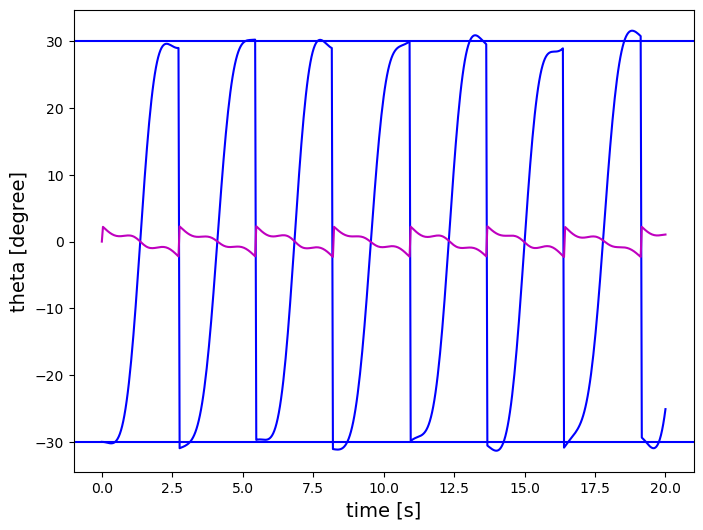

In [186]:
# state = theta, phi, thetadot, phidot
robot=Robot(R=1,l=0.2,r=0.1,R2=0.5,R3=0.15,m1=1,m2=1,m3=0.5,I1=0.01,I2=0.01,I3=0.001,ID=0.001,maxOmega=1.15,torqueLimit=3)
# robot=Robot(R=1,l=0.3,r=0.1,R2=0.5,R3=0.15,m1=1,m2=1,m3=0.5,I1=0.01,I2=0.01,I3=0.01,ID=0.01,maxOmega=1.5,torqueLimit=3)
# robot=Robot(R=1.5,l=0.3,r=0.1,R2=0.5,R3=0.15,m1=1,m2=1,m3=0.5,I1=0.01,I2=0.01,I3=0.01,ID=0.01,maxOmega=0.8,torqueLimit=3)
# robot=Robot(R=1.5,l=0.4,r=0.1,R2=0.5,R3=0.15,m1=1,m2=1,m3=0.5,I1=0.01,I2=0.01,I3=0.01,ID=0.01,maxOmega=1,torqueLimit=3)

timeVector,outputState,Points,changeList,torque=robot.Simulation(initialState=np.array([[-robot.beta],[-pi/2],[0.0],[robot.maxOmega]]),timeLength=20,QN=np.diag([0.]*4),RN=np.diag([0.]*2))
print(np.max(torque))

thetaValue=outputState[:,0]
phiValue=outputState[:,1]
thetadotValue=outputState[:,2]
phidotValue=outputState[:,3]
alphaValue=np.arcsin(robot.r/robot.l*sin(phiValue))
alphadotValue=robot.r/robot.l*cos(phiValue)/cos(alphaValue)*phidotValue
Mty=Points[:,1,-1]
plt.figure(figsize=(8,6))
plt.xlabel('time [s]', fontsize=14)
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.plot(timeVector,torque,'m')
plt.ylabel('theta [degree]',fontsize=14)
plt.axhline(-robot.beta*180/pi,color='b')
plt.axhline(robot.beta*180/pi,color='b')
plt.show()

error=  0.11218857248615882


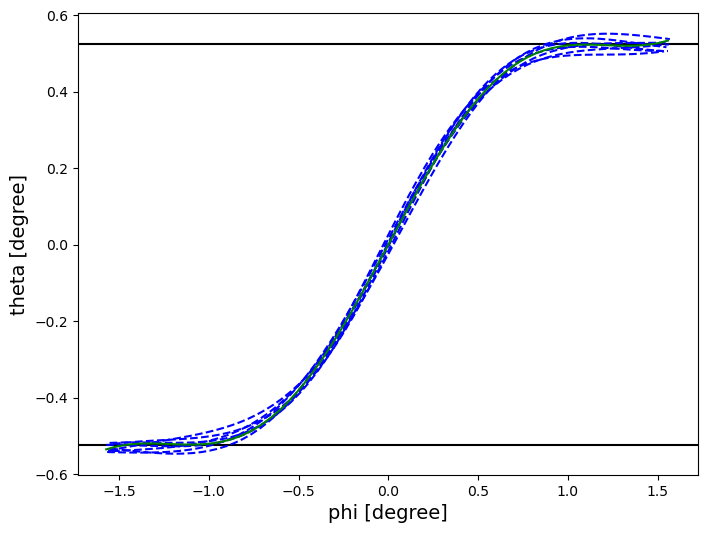

In [187]:
p1,p2,p3=robot.Calibrate(thetaValue,phiValue)
beta=robot.beta
plt.figure(figsize=(8,6))
plt.xlabel('phi [degree]', fontsize=14)
plt.ylabel('theta [degree]',fontsize=14)
plt.axhline(-beta,color='k')
plt.axhline(beta,color='k')
for i in range(1,len(changeList)):
    plt.plot(phiValue[changeList[i-1]:changeList[i]],thetaValue[changeList[i-1]:changeList[i]], 'b--')
plt.plot(phiValue[:changeList[1]],sin(phiValue[:changeList[1]]*p1)*p2+p3*phiValue[:changeList[1]], 'g')
plt.show()

Moving distance:  6.922653604420069


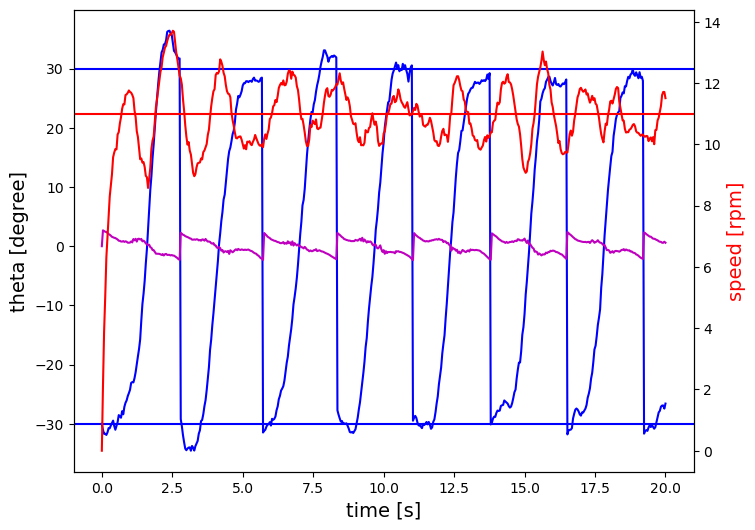

In [192]:
ratio=1
omega=robot.maxOmega*ratio
timeVector,outputState,Points,changeList,torque=robot.Simulation(initialState=np.array([[-robot.beta],[-pi/2],[0],[0.]]),omega=omega,timeLength=20,K1=5,K2=15*ratio) #,QN=np.diag([0.]*4),RN=np.diag([0.]*2)

print('Moving distance: ',Points[-1,0,-1])
thetaValue=outputState[:,0]
phiValue=outputState[:,1]
thetadotValue=outputState[:,2]
phidotValue=outputState[:,3]
alphaValue=np.arcsin(robot.r/robot.l*sin(phiValue))
alphadotValue=robot.r/robot.l*cos(phiValue)/cos(alphaValue)*phidotValue
Mty=Points[:,1,-1]
plt.figure(figsize=(8,6))
plt.xlabel('time [s]', fontsize=14)
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.plot(timeVector,torque, 'm')
plt.ylabel('theta [degree]',fontsize=14)
plt.axhline(-robot.beta*180/pi,color='b')
plt.axhline(robot.beta*180/pi,color='b')
rightax=plt.twinx()
rightax.plot(timeVector,phidotValue*30/pi, 'r')
rightax.set_ylabel('speed [rpm]',fontsize=14)
rightax.axhline(omega*30/pi,color='r')
rightax.yaxis.label.set_color('red')
plt.show()

In [191]:
imageScale=100
windowH=500
windowW=1000
speedPlayback=2
interval = robot.animationInterval/speedPlayback
last_update_time = time.time()-interval
WINDOW_NAME="Test"
cv2.namedWindow(WINDOW_NAME)
index=-1
R=robot.R
l=robot.l
r=robot.r
offset=np.array([250,windowH-10])
curve=[]
beta=np.arcsin(r/l)+5/180*pi
for i in range(17):
    angle=beta*(i/16*2-1)
    curve.append(R*np.array([sin(angle),cos(angle)]))
curve=np.array(curve)
while True:
    current_time = time.time()
    if ((current_time - last_update_time) >= interval):
        index+=1
        index%=outputState.shape[0]
        img = np.zeros((windowH, windowW, 3), np.uint8)
        cv2.line(img,(0,offset[1]),(windowW,offset[1]),(255,0,0),3)
        theta,phi,_,_=outputState[index]
        alpha=np.arcsin(r/l*sin(phi))
        P1,P2,Q1,Q2,M,Mt=(Points[index]*np.array([[1],[-1]])).T
        curves=[]
        Rotation1=np.array([
            [cos(theta),-sin(theta)],
            [sin(theta),cos(theta)]
        ])
        curve1=((curve@Rotation1.T+P1)*imageScale+offset).astype(np.int64)
        curves.append(curve1)
        Rotation2=np.array([
            [cos(theta-2*alpha),-sin(theta-2*alpha)],
            [sin(theta-2*alpha),cos(theta-2*alpha)]
        ])
        curve2=((curve@Rotation2.T+P2)*imageScale+offset).astype(np.int64)
        curves.append(curve2)
        cv2.polylines(img, curves,False,(255,255,255), 3)
        circleCenter=(M*imageScale+offset).astype(np.int64)
        cv2.circle(img,(circleCenter[0],circleCenter[1]),int(r*imageScale),(0,255,0),3)
        Q1Center=(Q1*imageScale+offset).astype(np.int64)
        Q2Center=(Q2*imageScale+offset).astype(np.int64)
        cv2.line(img,(Q1Center[0],Q1Center[1]),(Q2Center[0],Q2Center[1]),(0,255,0),3)
        Rotation3=np.array([
            [cos(theta-alpha),-sin(theta-alpha)],
            [sin(theta-alpha),cos(theta-alpha)]
        ])
        Hand3=(np.array([[0,-2*(l+r)*imageScale]])@Rotation3.T).astype(np.int64)
        cv2.line(img,(circleCenter[0],circleCenter[1]),(circleCenter[0]+Hand3[0,0],circleCenter[1]+Hand3[0,1]),(0,255,0),3)
        Rotation1=np.array([
            [cos(theta),-sin(theta)],
            [sin(theta),cos(theta)]
        ])
        P1Center=(P1*imageScale+offset).astype(np.int64)
        Hand1=(np.array([[0,R*imageScale]])@Rotation1.T).astype(np.int64)
        cv2.line(img,(P1Center[0],P1Center[1]),(P1Center[0]+Hand1[0,0],P1Center[1]+Hand1[0,1]),(0,0,255),3)
        Rotation2=np.array([
            [cos(theta-2*alpha),-sin(theta-2*alpha)],
            [sin(theta-2*alpha),cos(theta-2*alpha)]
        ])
        P2Center=(P2*imageScale+offset).astype(np.int64)
        Hand2=(np.array([[0,R*imageScale]])@Rotation2.T).astype(np.int64)
        cv2.line(img,(P2Center[0],P2Center[1]),(P2Center[0]+Hand2[0,0],P2Center[1]+Hand2[0,1]),(0,0,255),3)
        circleCenter=(Mt*imageScale+offset).astype(np.int64)
        cv2.circle(img,(circleCenter[0],circleCenter[1]),5,(0,255,255),-1)
        cv2.imshow(WINDOW_NAME, img)
        last_update_time = current_time

    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC key
        break
cv2.destroyAllWindows()